# Learning Permutation of a DAG

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# 1. Generate VAR(1) data, 2D and 3D

In [2]:
def generate_data(length, num_variables, A, Vx = 1, Vy = 1):

    # Initialize series
    series = np.array(np.zeros((length, num_variables)))

    P = np.array([[0.0, 1.0], [1.0, 0.0]])
    
    # Coupling strength
    axx = A[0][0] # influence of X_t-1 on X_t
    axy = A[1][0] # influence of X_t-1 on Y_t
    ayx = A[0][1] # influence of Y_t-1 on X_t
    ayy = A[1][1] # influence of Y_t-1 on Y_t
    
    # Generate series
    for t in range(1, length):
        # Generate VAR model
        series[t][0] = axx * series[t - 1][0] + ayx * series[t - 1][1] + np.random.normal(0, Vx)
        series[t][1] = ayy * series[t - 1][1] + axy * series[t - 1][0] + np.random.normal(0, Vy)
    
    return series

In [3]:
def generate_data_2(length, num_variables, A, Vx = 1, Vy = 1):

    # Initialize series
    series = np.array(np.zeros((length, num_variables)))

    P = np.array([[0.0, 1.0], [1.0, 0.0]])
    
    # Coupling strength
    axx = A[0][0] # influence of X_t-1 on X_t
    axy = A[1][0] # influence of X_t-1 on Y_t
    ayx = A[0][1] # influence of Y_t-1 on X_t
    ayy = A[1][1] # influence of Y_t-1 on Y_t
    
    # Generate series
    for t in range(1, length):
        # Generate VAR model
        series[t] = np.matmul(P.transpose(), np.matmul(A, np.matmul(P, series[t - 1]))) + np.random.multivariate_normal(np.zeros(2), np.identity(2))
    
    return series

In [4]:
def generate_data_3D(length, num_variables, A, Vx = 1, Vy = 1, Vz = 1):

    # Initialize series
    series = np.array(np.zeros((length, num_variables)))

    # Coupling strength
    axx = A[0][0] # influence of X_t-1 on X_t
    axy = A[1][0] # influence of X_t-1 on Y_t
    axz = A[2][0] # influence of X_t-1 on Y_t
    ayx = A[0][1] # influence of Y_t-1 on X_t
    ayy = A[1][1] # influence of Y_t-1 on Y_t
    ayz = A[2][1] # influence of Y_t-1 on Y_t
    azx = A[0][2] # influence of Y_t-1 on X_t
    azy = A[1][2] # influence of Y_t-1 on Y_t
    azz = A[2][2] # influence of Y_t-1 on Y_t
    
    # Generate series
    for t in range(1, length):
        # Generate VAR model
        series[t][0] = axx * series[t - 1][0] + ayx * series[t - 1][1] + azx * series[t - 1][2] + np.random.normal(0, Vx)
        series[t][1] = axy * series[t - 1][0] + ayy * series[t - 1][1] + azy * series[t - 1][2] + np.random.normal(0, Vy)
        series[t][2] = axz * series[t - 1][0] + ayz * series[t - 1][1] + azz * series[t - 1][2] + np.random.normal(0, Vz)
    
    return series

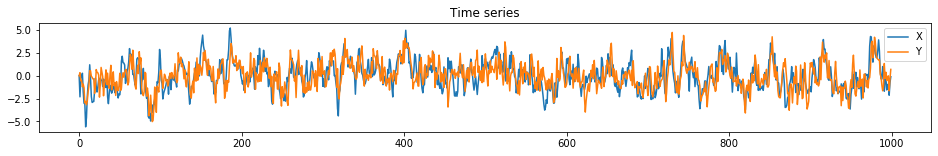

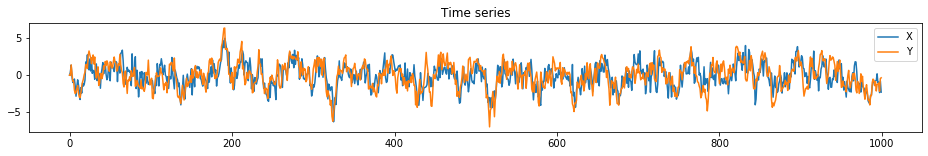

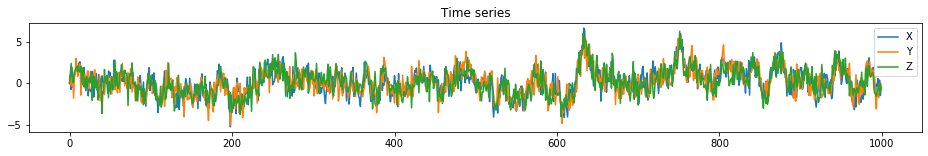

In [5]:
length, num_variables = 1000, 2
# Generate 2D data
A = [[0.8, 0.0], [0.4, 0.4]]
series_2D = generate_data(length, num_variables, A)

# Plot
plt.figure(figsize=(16,2))
plt.title("Time series")
plots = plt.plot(series_2D)
plt.legend(plots, ["X", "Y"], loc=1)
plt.show()

A = [[0.8, 0.0], [0.4, 0.4]]
series_2D = generate_data_2(length, num_variables, A)

# Plot
plt.figure(figsize=(16,2))
plt.title("Time series")
plots = plt.plot(series_2D)
plt.legend(plots, ["X", "Y"], loc=1)
plt.show()


# Generate 3D data
series_3D = generate_data_3D(length, 3, [[0.3, 0.3, 0.3], [0.3, 0.3, 0.3], [0.3, 0.3, 0.3]])

# Plot
plt.figure(figsize=(16,2))
plt.title("Time series")
plots = plt.plot(series_3D)
plt.legend(plots, ["X", "Y", "Z"], loc=1)
plt.show()

### Idea, estimate using OLS:
$$PX_t = APX_{t-1} \iff X_t = P^{-1} A P X_{t-1}$$
OLS Solution:
$$X^TX \left(P^{-1}AP\right)_{(i, \cdot)}^T = X^TX_i.$$
where 
$$X_i := \begin{pmatrix} X_{i,1}, & X_{i,2}, & \cdots, & X_{i, T} \end{pmatrix}^T \in \mathbb{R}^T$$
$$X := \begin{pmatrix} 0, & 0, & \cdots, & 0 \\ X_{1,1} & X_{2,1} & \cdots & X_{n, 1} \\ \vdots & \vdots & \ddots & \vdots \\ X_{1,T-1}, & X_{2, T-1}, & \cdots, & X_{n, T-1}\end{pmatrix} \in \mathbb{R}^T$$

$$ \begin{pmatrix} X_{i,1} \\ X_{i,2} \\ \cdots \\ X_{i, T} \end{pmatrix} = \begin{pmatrix} 0, & 0, & \cdots, & 0 \\ X_{1,1} & X_{2,1} & \cdots & X_{n, 1} \\ \vdots & \vdots & \ddots & \vdots \\ X_{1,T-1}, & X_{2, T-1}, & \cdots, & X_{n, T-1}\end{pmatrix} \begin{pmatrix} \left(P^{-1}AP\right)_{i,1} \\ \left(P^{-1}AP\right)_{i,2} \\ \cdots \\ \left(P^{-1}AP\right)_{i,n} \end{pmatrix}$$

So, for each $X_i$, we can separately estimate the corresponding row $\left(P^{-1}AP\right)_{i}$. After having estimated all these, we can retrieve $\left(P^{-1}AP\right)$ by stacking all the rows. 

### Retrieving $A$
Once we have $\left(P^{-1}AP\right)$, we can retrieve $A$ if we know $P$. We can simply get $$A = P\left(P^{-1}AP\right)P^{-1}.$$

### Retrieving $P$
Once we have $\left(P^{-1}AP\right)$, we want to retrieve $P$ given our value for $A$.

In [6]:
import statsmodels.api as sm
import scipy

P = np.array([[0.0, 1.0], [1.0, 0.0]])
A = [[0.8, 0.0], [0.4, 0.4]]
series_2D = generate_data_2(length, num_variables, A)

def PinvAP_to_A(PinvAP, P = P):
    # A = P inv(P) A P inv(P)
    return np.matmul(P, np.matmul(PinvAP, scipy.linalg.inv(P)))

def PinvAP_to_P(PinvAP, A = A):
    # P = sqrt(inv(B)) * sqrt(A)
    sqrtPinvAP = scipy.linalg.sqrtm(scipy.linalg.inv(PinvAP))
    sqrtinvA = scipy.linalg.sqrtm(A)
    return np.matmul(sqrtinvA, sqrtPinvAP)

def PinvAP_to_P_2(PinvAP, A = A):
    # P = sqrt(inv(B)) * sqrt(A)
    return scipy.linalg.schur(PinvAP)
    
# OLS Solution
# Write in the form y_i = X_i beta_i
y_1 = series_2D[:, 0]
y_2 = series_2D[:, 1]

X_1 = np.insert(series_2D[:-1, :], 0, np.zeros(2), axis=0)

est_1 = sm.OLS(y_1, X_1).fit()
est_2 = sm.OLS(y_2, X_1).fit()

print(est_1.params, est_2.params)
PinvAP = np.array([est_1.params, est_2.params])

A_est = PinvAP_to_A(PinvAP)
P_est = PinvAP_to_P(PinvAP)

Z, T = PinvAP_to_P_2(PinvAP)
print("Z, T:", Z, T)

print("inv(P) A P: ", PinvAP)
print("A_est:", A_est)
print("inv(P) A_est P: ", np.matmul(scipy.linalg.inv(P), np.matmul(A_est, P)))
print("P_est:", P_est)
print("inv(P_est) A P_est: ", np.matmul(scipy.linalg.inv(P_est), np.matmul(A, P_est)))

ModuleNotFoundError: No module named 'statsmodels'

# 2. Methods
## 2.1 Cost function 1
$$C_1 = \arg \min_{p \in [0, 1],\ a_{11},\ a_{12}, a_{22} \in \mathbb{R}}: \frac{1}{T}\sum_{t=2}^T\left\lVert PX_t - APX_{t-1}\right\rVert_{2*}^2.$$
2*: We omit the last entry.

In [146]:
def C_1(variables, l = 0.01):
    p, a = variables
    
    cost_1, cost_2 = 0, 0
    for t in range(1, length):
        val_1 = series[t][0]
        est_1 = a * series[t - 1][1]
        cost_1 += (val_1 - est_1) ** 2
        
        val_2 = series[t][1]
        est_2 = a * series[t- 1][0]
        cost_2 += (val_2 - est_2) ** 2
    
    return (p * cost_1 + (1 - p) * cost_2) / length # l * (abs(axx) + abs(axy) + abs(ayy))

In [187]:
length = 50000

for i in range(10):
    series = generate_data(length, num_variables, [[0.4, 0.4], [0.0, 0.4]])
    results = optimize.minimize(C_1, [0.5, 1], constraints = optimize.LinearConstraint(np.identity(2), [0, -10000], [1, 10000])).x
    print(f"p = {round(results[0], 5)}.")

p = 1.0.
p = 1.0.
p = 1.0.
p = 1.0.
p = 1.0.
p = 1.0.
p = 1.0.
p = 1.0.
p = 1.0.
p = 1.0.


In [ ]:
length = 5000

for i in range(10):
    series = generate_data(length, num_variables, [[0.4, 0.4], [0.0, 0.4]])
    results = optimize.minimize(C2, [0.0, 0.0, 0.0, 0.0]).x
    print(f"p = {round(results[0], 5)}.")

In [98]:
results = optimize.minimize(C1_given_p, [1, 1, 1, 1]).x
print(f"axx = {round(results[0], 3)}, axy = {round(results[1], 3)}, ayx = {round(results[2], 3)}, ayy = {round(results[3], 3)}.")

NameError: name 'C1_given_p' is not defined

## 2.2 Cost function 2
$$C_2 = \arg \min_{p \in [0, 1],\ A \text{ is UT} \in \mathbb{R}^{2 \times 2}}: \sum_{t=2}^T\left\lVert PX_t - APX_{t-1}\right\rVert_2^2.$$

In [137]:
def C2(variables, l = 0.01):
    p, axx, axy, ayy = variables
    p = round(p, 8)
    
    x_cost, y_cost = 0, 0
    for t in range(1, length):
        x_val = p * series[t][0] + (1 - p) * series[t][1]
        x_est = axx * (p * series[t - 1][0] + (1 - p) * series[t - 1][1] \
                      + axy * ((1 - p) * series[t - 1][0] + p * series[t - 1][1]))
        x_cost += (x_val - x_est) ** 2
        
        y_val = p * series[t][1] + (1 - p) * series[t][0]
        y_est = ayy * ((1 - p) * series[t - 1][0] + p * series[t - 1][1])
        y_cost += (y_val - y_est) ** 2
    
    return x_cost + y_cost # + l * (abs(axx) + abs(axy) + abs(ayy))

def C2_2(variables, l = 0.01):
    p, a11, a12, a22 = variables
    
    A = np.array([[a11, 0], [a12, a22]])
    P = np.array([[p, 1 - p], [1 - p, p]])
    
    cost = 0
    
    for t in range(1, length):
        val = np.matmul(P, series[t])
        est = np.matmul(A, np.matmul(P, series[t - 1]))
        cost += np.linalg.norm(val - est) ** 2
    
    return cost + l * (np.sum(np.abs(A)))

In [157]:
var = np.random.uniform(0,1,4)
print(C2(var), C2_2(var))

262.0381043819289 262.03810629156874


In [435]:
def run_inference(func, length, num_samples, tries_per_sample, A, generate = True):
    # Average p of all tries
    p_avg_total = np.array([])
    a1_avg_total = np.array([])
    a2_avg_total = np.array([])
    a3_avg_total = np.array([])
    
    # Compute minimization for num_samples samples
    for i in range(num_samples):
        # print(f"Sample {i + 1}: ", end = "\t")
        
        # List containing averages
        p_avg = np.array([])
        a1_avg = np.array([])
        a2_avg = np.array([])
        a3_avg = np.array([])
        
        # Generate data
        global series
        if generate:
            series = generate_data(length = length, num_variables = 2, A = A)
        
        # Run minimization for this data tries_per_sample times
        for j in range(tries_per_sample):
            # Generate p uniformly at random
            new_p = np.random.uniform(0, 1)
            
            # Minimize and get results
            results = optimize.minimize(func, [new_p, 0, 0, 0]).x
            
            # Append results to list
            p_avg = np.append(p_avg, results[0])
            a1_avg = np.append(a1_avg, results[1])
            a2_avg = np.append(a2_avg, results[2])
            a3_avg = np.append(a3_avg, results[3])
            
            # print(round(p_avg[j], 3), end ="\t, ")
        
        # Append averaged result to list
        p_avg_total = np.append(p_avg_total, sum(p_avg) / len(p_avg))
        a1_avg_total = np.append(a1_avg_total, sum(a1_avg) / len(a1_avg))
        a2_avg_total = np.append(a2_avg_total, sum(a2_avg) / len(a2_avg))
        a3_avg_total = np.append(a3_avg_total, sum(a3_avg) / len(a3_avg))
        # print(f"Average: {round(p_avg_total[i], 3)}.", end = "\t")
    return sum(p_avg_total) / len(p_avg_total), sum(a1_avg_total) / len(a1_avg_total), sum(a2_avg_total) / len(a2_avg_total), sum(a3_avg_total) / len(a3_avg_total)

In [173]:
# Generate 2D data
series = generate_data(length, num_variables, [[0.8, 0.4], [0.0, 0.4]])

results = optimize.minimize(C2, [0.0, 0, 0, 0]).x #, constraints = optimize.LinearConstraint(np.identity(4), [0, -10000, -10000, -10000], [1, 10000, 10000, 10000])).x
print(C2(results))
print(f"p = {round(results[0], 3)}, a11 = {round(results[1], 5)}, a12 = {round(results[2], 3)} , a22 = {round(results[3], 3)}.")
print(f"P = {[[round(results[0], 0), 1 - round(results[0], 0)], [1 - round(results[0], 0), round(results[0], 0)]]}.")

results = optimize.minimize(C2_2, [1.0, 0, 0, 0]).x #, constraints = optimize.LinearConstraint(np.identity(4), [0, -10000, -10000, -10000], [1, 10000, 10000, 10000])).x
print(C2_2(results))
print(f"p = {round(results[0], 3)}, a11 = {round(results[1], 5)}, a12 = {round(results[2], 3)} , a22 = {round(results[3], 3)}.")
print(f"P = {[[round(results[0], 0), 1 - round(results[0], 0)], [1 - round(results[0], 0), round(results[0], 0)]]}.")

108.16726237888584
p = 0.453, a11 = -1.43134, a12 = 2.245 , a22 = 0.805.
P = [[0.0, 1.0], [1.0, 0.0]].
108.16726237888626
p = 0.453, a11 = -1.43135, a12 = 2.245 , a22 = 0.805.
P = [[0.0, 1.0], [1.0, 0.0]].


## 3. Examples
### 3.1 Example 1, no relation whatsoever


Total Average: (0.35954146003692683, -0.15815561734059486, 1.0765630442220444, 0.835418697128652).


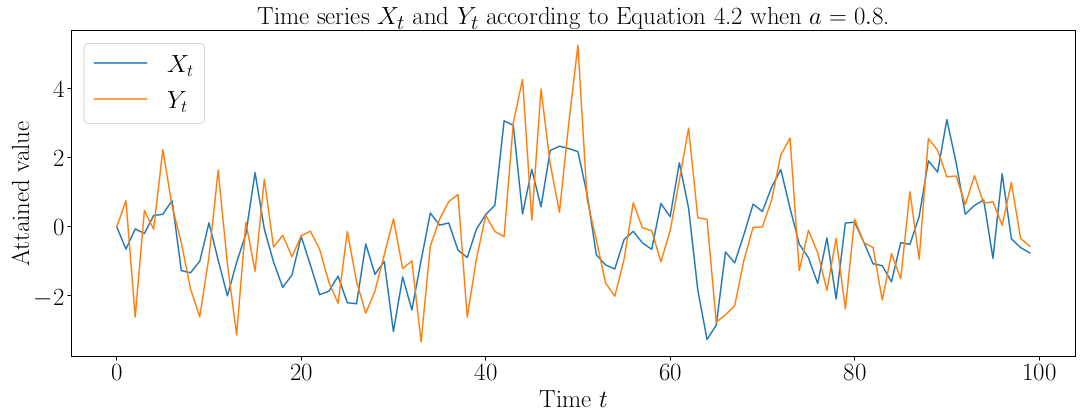

In [523]:
num_samples, tries_per_sample = 20, 8
matplotlib.use("pgf")
plt.rc('pgf', texsystem='pdflatex') 
matplotlib.rcParams['axes.unicode_minus'] = False

a = 0.8
A = [[a, 0.0], [1.0, 0.0]]
# series = generate_data(length = length, num_variables = 2, A = A)
plt.figure(figsize = (18,6))
plt.rcParams.update({'font.size': 26})
plt.plot(series)
plt.legend(labels = ["$X_t$", "$Y_t$"])
plt.title("Time series $X_t$ and $Y_t$ according to Equation 4.2 when $a = 0.8$.")
plt.xlabel("Time $t$")
plt.ylabel("Attained value")
print(f"\nTotal Average: {(run_inference(C2, length, num_samples, tries_per_sample, A))}.")

if os.path.exists('../figs/series_plot.pgf'):
    plt.savefig('../figs/series_plot_{}.pgf'.format(int(time.time())))
else:
    plt.savefig('../figs/series_plot.pgf')

Text(0.5, 1.0, 'Value of $p$ as a function of $a$')

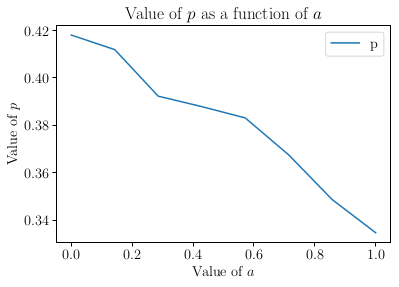

In [492]:
a_list = np.linspace(0.0, 1.0, 8)
p_list = np.array([])
for a in a_list:
    A = [[a, 0.0], [1.0, 0.0]]   
    p_list = np.append(p_list, run_inference(C2, length, 40, 8, A)[0])
    # print(f"Total Average: {(run_inference(C2, length, 1, 1, A)[0])}.")
plt.plot(a_list, p_list)
plt.xlabel("Value of $a$")
plt.ylabel("Value of $p$")
plt.legend("p")
plt.title("Value of $p$ as a function of $a$")

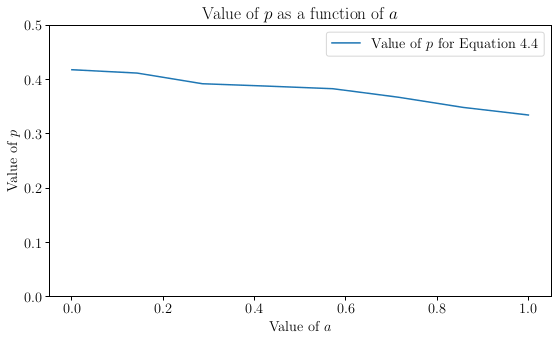

In [493]:
plt.figure(figsize = (9,5))
plt.plot(a_list, p_list)
plt.xlabel("Value of $a$")
plt.ylabel("Value of $p$")
plt.ylim(0.0,.5)
plt.legend(["Value of $p$ for Equation 4.4"])
plt.title("Value of $p$ as a function of $a$")

import matplotlib
matplotlib.use("pgf")
plt.rc('pgf', texsystem='pdflatex') 

import time, os
if os.path.exists('../figs/p_plot.pgf'):
    plt.savefig('../figs/p_plot_{}.pgf'.format(int(time.time())))
else:
    plt.savefig('../figs/p_plot.pgf')

In [181]:
num_samples, tries_per_sample = 2, 10

print("We expect averages to be around 0.5, as there is no relation.")

# 1.1, equal low self-coupling
A = [[0.2, 0.0], [0.0, 0.2]]
series = generate_data(length = length, num_variables = 2, A = A)
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")
print(f"Total Average\n: {round(run_inference(C2_2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.2, equal medium self-coupling
A = [[0.5, 0.0], [0.0, 0.5]]
series = generate_data(length = length, num_variables = 2, A = A)
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")
print(f"Total Average\n: {round(run_inference(C2_2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.3, equal high self-coupling
A = [[0.8, 0.0], [0.0, 0.8]]
series = generate_data(length = length, num_variables = 2, A = A)
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")
print(f"Total Average\n: {round(run_inference(C2_2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.4, un-equal low-high self-coupling
A = [[0.2, 0.0], [0.0, 0.8]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")
print(f"Total Average\n: {round(run_inference(C2_2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.5, un-equal medium-high self-coupling
A = [[0.5, 0.0], [0.0, 0.8]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")
print(f"Total Average\n: {round(run_inference(C2_2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.6, un-equal low-medium self-coupling
A = [[0.2, 0.0], [0.5, 0.5]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")
print(f"Total Average\n: {round(run_inference(C2_2, length, num_samples, tries_per_sample, A), 3)}.")

We expect averages to be around 0.5, as there is no relation.

Total Average: 0.503.
Total Average
: 0.509.

Total Average: 0.496.
Total Average
: 0.495.

Total Average: 0.5.
Total Average
: 0.498.

Total Average: 0.51.
Total Average
: 0.513.

Total Average: 0.484.
Total Average
: 0.505.

Total Average: 0.526.
Total Average
: 0.53.


### 3.2 Example 2, Clear $X \rightarrow Y$

In [185]:
num_samples, tries_per_sample = 5, 2

print("We expect p to be smaller than 0.5, as X influences Y.")

# 1.1, low X -> X, low X -> Y
A = [[0.2, 0.2], [0.0, 0.0]]
series = generate_data(length = length, num_variables = 2, A = A)
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.2, low X -> X, medium X -> Y
A = [[0.2, 0.5], [0.0, 0.0]]
series = generate_data(length = length, num_variables = 2, A = A)
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.3, low X -> X, high X -> Y
A = [[0.2, 0.8], [0.0, 0.0]]
series = generate_data(length = length, num_variables = 2, A = A)
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.4, medium X -> X, low X -> Y
A = [[0.5, 0.2], [0.0, 0.0]]
series = generate_data(length = length, num_variables = 2, A = A)
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.5, medium X -> X, medium X -> Y
A = [[0.5, 0.5], [0.0, 0.0]]
series = generate_data(length = length, num_variables = 2, A = A)
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.6, medium X -> X, high X -> Y
A = [[0.5, 0.8], [0.0, 0.0]]
series = generate_data(length = length, num_variables = 2, A = A)
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.7, high X -> X, low X -> Y
A = [[0.8, 0.2], [0.0, 0.0]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.8, high X -> X, medium X -> Y
A = [[0.8, 0.5], [0.0, 0.0]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.9, high X -> X, high X -> Y
A = [[0.8, 0.8], [0.0, 0.0]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

We expect p to be smaller than 0.5, as X influences Y.

Total Average: 0.491.

Total Average: 0.454.

Total Average: 0.428.

Total Average: 0.482.

Total Average: 0.448.

Total Average: 0.397.

Total Average: 0.44.

Total Average: 0.401.

Total Average: 0.393.


In [1055]:
num_samples, tries_per_sample = 5, 2

print("We expect p to be smaller than 0.5, as X influences Y.")

# 1.1, low X -> X, low X -> Y
A = [[0.2, 0.2], [0.0, 0.0]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")

# 1.2, low X -> X, medium X -> Y
A = [[0.2, 0.5], [0.0, 0.0]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")

# 1.3, low X -> X, high X -> Y
A = [[0.2, 0.8], [0.0, 0.0]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")

# 1.4, medium X -> X, low X -> Y
A = [[0.5, 0.2], [0.0, 0.0]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")

# 1.5, medium X -> X, medium X -> Y
A = [[0.5, 0.5], [0.0, 0.0]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")

# 1.6, medium X -> X, high X -> Y
A = [[0.5, 0.8], [0.0, 0.0]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")

# 1.7, high X -> X, low X -> Y
A = [[0.8, 0.2], [0.0, 0.0]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")

# 1.8, high X -> X, medium X -> Y
A = [[0.8, 0.5], [0.0, 0.0]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")

# 1.9, high X -> X, high X -> Y
A = [[0.8, 0.8], [0.0, 0.0]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")

We expect p to be smaller than 0.5, as X influences Y.

Total Average: 0.496.

Total Average: 0.445.

Total Average: 0.42.

Total Average: 0.466.

Total Average: 0.435.

Total Average: 0.393.

Total Average: 0.446.

Total Average: 0.451.

Total Average: 0.369.


### 3.3 Example 3, Clear $Y \rightarrow X$

In [188]:
num_samples, tries_per_sample = 5, 2

print("We expect p to be larger than 0.5, as Y influences X.")

# 1.1, low Y -> Y, low X -> Y
A = [[0.0, 0.0], [0.2, 0.2]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.2, low X -> X, medium X -> Y
A = [[0.0, 0.0], [0.2, 0.5]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.3, low X -> X, high X -> Y
A = [[0.0, 0.0], [0.2, 0.8]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.4, medium X -> X, low X -> Y
A = [[0.0, 0.0], [0.5, 0.2]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.5, medium X -> X, medium X -> Y
A = [[0.0, 0.0], [0.5, 0.5]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.6, medium X -> X, high X -> Y
A = [[0.0, 0.0], [0.5, 0.8]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.7, high X -> X, low X -> Y
A = [[0.0, 0.0], [0.8, 0.2]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.8, high X -> X, medium X -> Y
A = [[0.0, 0.0], [0.8, 0.5]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

# 1.9, high X -> X, high X -> Y
A = [[0.0, 0.0], [0.8, 0.8]]
print(f"\nTotal Average: {round(run_inference(C2, length, num_samples, tries_per_sample, A), 3)}.")

We expect p to be larger than 0.5, as Y influences X.

Total Average: 0.516.

Total Average: 0.514.

Total Average: 0.549.

Total Average: 0.526.

Total Average: 0.536.

Total Average: 0.567.

Total Average: 0.557.

Total Average: 0.606.

Total Average: 0.618.


### 3.4 Example 4, equal influence

In [1057]:
num_samples, tries_per_sample = 5, 2

print("We expect p to be around 0.5, as influences are equal. ")

# 4.1, low self X, low self Y, low XY / YX 
A = [[0.2, 0.2], [0.2, 0.2]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")

# 4.2, medium self X, medium self Y, medium XY / YX 
A = [[0.5, 0.5], [0.5, 0.5]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")

# 4.3, low self X, low self Y, high XY / YX 
A = [[0.2, 0.8], [0.8, 0.2]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")

# 4.3, high self X, high self Y, low XY / YX 
A = [[0.8, 0.2], [0.2, 0.8]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")

We expect p to be around 0.5, as influences are equal. 

Total Average: 0.498.

Total Average: 0.505.

Total Average: 0.504.

Total Average: 0.503.


### 3.5 Example 5, Equal influence?

In [1058]:
num_samples, tries_per_sample = 5, 2

# 5.1, low self X, medium self Y, medium XY / YX 
A = [[0.1, 0.5], [0.5, 0.5]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")

# 5.2, influence of X on X / influence of Y on X < influence of Y on Y / influence of X on Y
A = [[0.1, 0.5], [0.2, 0.5]]
print(f"\nTotal Average: {round(run_inference(cost_2D, length, num_samples, tries_per_sample, A), 3)}.")


Total Average: 0.514.

Total Average: 0.508.


### 3.6 Contour plot for $a_{11}$, $a_{12}$ when $a_{21} = a_{22} = 0$ so that $X \rightarrow Y$

In [515]:
import matplotlib.cm as cm

num = 10
x = np.linspace(0.0, 1.0, num)
y = np.linspace(0.0, 1.0, num)
X, Y = np.meshgrid(x, y)

Z = np.array(np.zeros((num, num)))

num_samples = 1
tries_per_sample = 1
for i in range(num):
    print(f"{i / num * 100}%..., ,", end = "")
    for j in range(num):
        A = [[x[i], 0], [x[j], 0]]
        Z[i][j] = run_inference(C2, length, 1, 3, A)[0]

0.0%..., ,10.0%..., ,20.0%..., ,30.0%..., ,40.0%..., ,50.0%..., ,60.0%..., ,70.0%..., ,80.0%..., ,90.0%..., ,

<ipython-input-510-e896978d7af1>:7: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


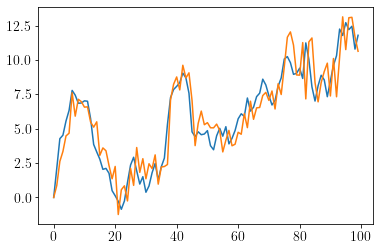

In [510]:
import matplotlib.pyplot as plt
length, num_variables = 100, 2
# Generate 2D data
series = generate_data(length, num_variables, [[1, 0.0], [1, 0.0]])
matplotlib.use("pdf")
plt.plot(series)
plt.show()

0.0%..., ,20.0%..., ,40.0%..., ,60.0%..., ,80.0%..., ,

<ipython-input-544-f996650d2bd2>:34: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


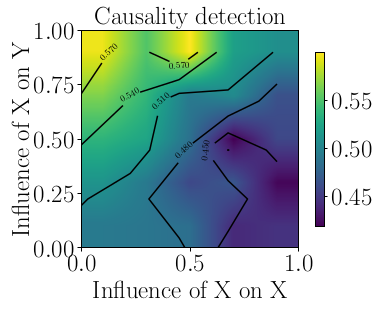

In [544]:
num = 5
x = np.linspace(0.0, 0.9, num)
y = np.linspace(0.0, 0.9, num)
X, Y = np.meshgrid(x, y)

Z = np.array(np.zeros((num, num)))

num_samples = 2
tries_per_sample = 2
for i in range(num):
    print(f"{i / num * 100}%..., ,", end = "")
    for j in range(num):
        A = [[0, x[j]], [x[i], 0]]
        Z[i][j] = run_inference(C2_2, length, 1, 3, A)[0]
        
fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
               cmap=cm.viridis, extent=(0, 1, 0, 1))

ax.set_title('Causality detection')
ax.set_xlabel('Influence of X on X')
ax.set_ylabel('Influence of X on Y')

CS = ax.contour(X, Y, Z, 6, colors='k')  # Negative contours default to dashed.
ax.clabel(CS, fontsize=9, inline=True)

# We can still add a colorbar for the image, too.
CBI = fig.colorbar(im, orientation='vertical', shrink=0.8)

# l, b, w, h = ax.get_position().bounds
# ll, bb, ww, hh = CB.ax.get_position().bounds
# CB.ax.set_position([ll, b + 0.1*h, ww, h*0.8])

plt.show()

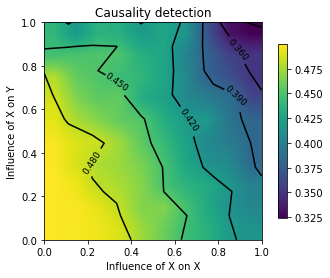

In [912]:
x = np.linspace(0.0, 1.0, num)
y = np.linspace(0.0, 1.0, num)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
               cmap=cm.viridis, extent=(0, 1, 0, 1))

ax.set_title('Causality detection')
ax.set_xlabel('Influence of X on X')
ax.set_ylabel('Influence of X on Y')

CS = ax.contour(X, Y, Z, 6, colors='k')  # Negative contours default to dashed.
ax.clabel(CS, fontsize=9, inline=True)

# We can still add a colorbar for the image, too.
CBI = fig.colorbar(im, orientation='vertical', shrink=0.8)

l, b, w, h = ax.get_position().bounds
ll, bb, ww, hh = CB.ax.get_position().bounds
CB.ax.set_position([ll, b + 0.1*h, ww, h*0.8])

plt.show()

In [534]:
num = 10
x = np.linspace(0.0, 1.0, num)
y = np.linspace(0.0, 1.0, num)
print(x)

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


0.0%..., ,20.0%..., ,40.0%..., ,60.0%..., ,80.0%..., ,

<ipython-input-533-b1792baa6cb2>:36: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


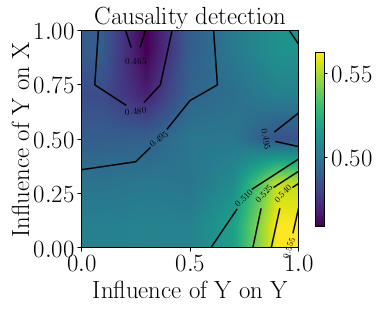

In [533]:
import matplotlib.cm as cm

num = 5
x = np.linspace(0.0, 0.95, num)
y = np.linspace(0.0, 0.95, num)
X, Y = np.meshgrid(x, y)

Z = np.array(np.zeros((num, num)))

num_samples = 5
tries_per_sample = 5
for i in range(num):
    print(f"{i / num * 100}%..., ,", end = "")
    for j in range(num):
        A = [[x[i], 0], [0, x[j]]]
        Z[i][j] = run_inference(C2, length, num_samples, tries_per_sample, A)[0]
        
x = np.linspace(0.0, 1.0, num)
y = np.linspace(0.0, 1.0, num)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
               cmap=cm.viridis, extent=(0, 1, 0, 1))

ax.set_title('Causality detection')
ax.set_xlabel('Influence of Y on Y')
ax.set_ylabel('Influence of Y on X')

CS = ax.contour(X, Y, Z, 6, colors='k')  # Negative contours default to dashed.
ax.clabel(CS, fontsize=9, inline=True)

# We can still add a colorbar for the image, too.
CBI = fig.colorbar(im, orientation='vertical', shrink=0.8)

plt.show()

0.0%..., ,6.666666666666667%..., ,13.333333333333334%..., ,20.0%..., ,26.666666666666668%..., ,33.33333333333333%..., ,40.0%..., ,46.666666666666664%..., ,53.333333333333336%..., ,60.0%..., ,66.66666666666666%..., ,73.33333333333333%..., ,80.0%..., ,86.66666666666667%..., ,93.33333333333333%..., ,

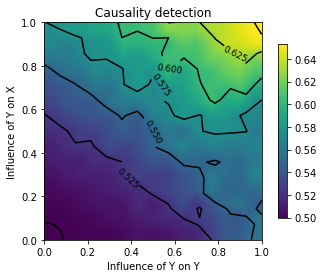

In [418]:
import matplotlib.cm as cm

num = 15
x = np.linspace(0.0, 0.95, num)
y = np.linspace(0.0, 0.95, num)
X, Y = np.meshgrid(x, y)

Z = np.array(np.zeros((num, num)))

num_samples = 30
tries_per_sample = 5
for i in range(num):
    print(f"{i / num * 100}%..., ,", end = "")
    for j in range(num):
        A = [[0, 0], [x[i], x[j]]]
        Z[i][j] = run_inference(C2, length, num_samples, tries_per_sample, A)
        
x = np.linspace(0.0, 1.0, num)
y = np.linspace(0.0, 1.0, num)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
               cmap=cm.viridis, extent=(0, 1, 0, 1))

ax.set_title('Causality detection')
ax.set_xlabel('Influence of Y on Y')
ax.set_ylabel('Influence of Y on X')

CS = ax.contour(X, Y, Z, 6, colors='k')  # Negative contours default to dashed.
ax.clabel(CS, fontsize=9, inline=True)

# We can still add a colorbar for the image, too.
CBI = fig.colorbar(im, orientation='vertical', shrink=0.8)

plt.show()

0.0%..., ,10.0%..., ,20.0%..., ,30.0%..., ,40.0%..., ,50.0%..., ,60.0%..., ,70.0%..., ,80.0%..., ,90.0%..., ,

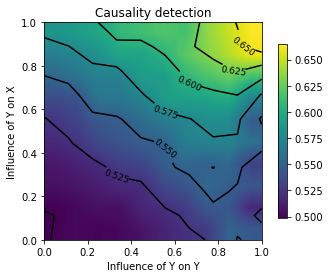

In [416]:
import matplotlib.cm as cm

num = 10
x = np.linspace(0.0, 1.0, num)
y = np.linspace(0.0, 1.0, num)
X, Y = np.meshgrid(x, y)

Z = np.array(np.zeros((num, num)))

num_samples = 30
tries_per_sample = 5
for i in range(num):
    print(f"{i / num * 100}%..., ,", end = "")
    for j in range(num):
        A = [[0, 0], [x[i], x[j]]]
        Z[i][j] = run_inference(C2, length, num_samples, tries_per_sample, A)
        
x = np.linspace(0.0, 1.0, num)
y = np.linspace(0.0, 1.0, num)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
               cmap=cm.viridis, extent=(0, 1, 0, 1))

ax.set_title('Causality detection')
ax.set_xlabel('Influence of Y on Y')
ax.set_ylabel('Influence of Y on X')

CS = ax.contour(X, Y, Z, 6, colors='k')  # Negative contours default to dashed.
ax.clabel(CS, fontsize=9, inline=True)

# We can still add a colorbar for the image, too.
CBI = fig.colorbar(im, orientation='vertical', shrink=0.8)

plt.show()

### 3.6 Contour plot when  $a_{11} = a_{22}$ and $a_{12} = a_{21}$.

In [ ]:
import matplotlib.cm as cm

num = 10
x = np.linspace(0.0, 1.0, num)
y = np.linspace(0.0, 1.0, num)
X, Y = np.meshgrid(x, y)

Z = np.array(np.zeros((num, num)))
Z[:] = np.NAN

num_samples = 3
tries_per_sample = 3
for i in range(num):
    print(f"{i / num * 100}%..., ,", end = "")
    for j in range(num):
        A = [[x[i], x[j]], [x[j], x[i]]]
        Z[i][j] = run_inference(cost_2D, length, 5, 5, A)

In [1109]:
import matplotlib.cm as cm

num = 50
x = np.linspace(0.0, 1.0, num)
y = np.linspace(0.0, 1.0, num)
X, Y = np.meshgrid(x, y)

Z = np.array(np.zeros((num, num)))
Z[:] = np.NAN

num_samples = 3
tries_per_sample = 3
for i in range(num):
    print(f"{i / num * 100}%..., ,", end = "")
    for j in range(num - i):
        A = [[x[i], x[j]], [x[j], x[i]]]
        Z[i][j] = run_inference(cost_2D, length, 5, 5, A)

0.0%..., ,2.0%..., ,4.0%..., ,6.0%..., ,8.0%..., ,10.0%..., ,12.0%..., ,14.000000000000002%..., ,16.0%..., ,18.0%..., ,20.0%..., ,22.0%..., ,24.0%..., ,26.0%..., ,28.000000000000004%..., ,30.0%..., ,32.0%..., ,34.0%..., ,36.0%..., ,38.0%..., ,40.0%..., ,42.0%..., ,44.0%..., ,46.0%..., ,48.0%..., ,50.0%..., ,52.0%..., ,54.0%..., ,56.00000000000001%..., ,57.99999999999999%..., ,60.0%..., ,62.0%..., ,64.0%..., ,66.0%..., ,68.0%..., ,70.0%..., ,72.0%..., ,74.0%..., ,76.0%..., ,78.0%..., ,80.0%..., ,82.0%..., ,84.0%..., ,86.0%..., ,88.0%..., ,90.0%..., ,92.0%..., ,94.0%..., ,96.0%..., ,98.0%..., ,

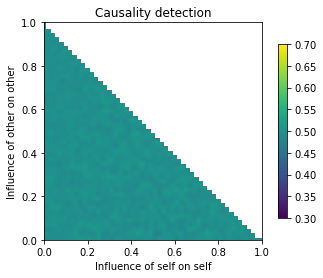

In [1113]:
x = np.linspace(0.0, 1.0, num)
y = np.linspace(0.0, 1.0, num)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
               cmap=cm.viridis, extent=(0, 1, 0, 1), vmin = 0.3, vmax = 0.7)

ax.set_title('Causality detection')
ax.set_xlabel('Influence of self on self')
ax.set_ylabel('Influence of other on other')

# CS = ax.contour(X, Y, Z, 0, colors='k')  # Negative contours default to dashed.
ax.clabel(CS, fontsize=9, inline=True)

# We can still add a colorbar for the image, too.
CBI = fig.colorbar(im, orientation='vertical', shrink=0.8)

l, b, w, h = ax.get_position().bounds
ll, bb, ww, hh = CB.ax.get_position().bounds
CB.ax.set_position([ll, b + 0.1*h, ww, h*0.8])

plt.show()

# 4. Conclusions
If X clearly influences Y, then we expect that the permutation matrix $P = I$. 

If Y clearly influences X, then we expect that the permutation matrix $P$ = ((0, 1), (1, 0)).

If there is no influence in any direction, we expect $p \in [0.5 \pm \epsilon]$.

If there is equal influence in both directions, we expect $p \in [0.5 \pm \epsilon]$.

Interestingly, it seems to be the other way around for $X \rightarrow Y$ and $X \leftarrow Y$. Writing things out, this makes sense, as, for $p = 0$, we have that $X$ is solely used to predict $Y$.

$$Y_t = a_{11}Y_{t-1} - a_{12}X_{t-1},\qquad X_t = a_{22}X_{t-1}.$$

For $p = 1$, we have that $Y$ is solely used to predict $X$.

$$X_t = a_{11}X_{t-1} - a_{12}Y_{t-1},\qquad Y_t = a_{22}Y_{t-1}.$$

For any value for $p$ in between, the influence is more in between.

# 5. Three variables
$$C_3 = \arg \min_{P,\ A \text{ is UT} \in \mathbb{R}^{3 \times 3}}: \sum_{t=2}^T\left\lVert PX_t - APX_{t-1}\right\rVert_2^2.$$

In [ ]:
def cost_3D(variables, l = 0.01):
    p11, p22, p33, p12, a11, a12, a13, a22, a23, a33 = variables
    
    A = np.array([[a11, a12, a13], [0, a22, a23], [0, 0, a33]])
    P = np.array([[p11, p12, 1 - p11 - p12], [1 - p22 - (1 - (1 - p11 - p12) - p33), p22, 1 - (1 - p11 - p12) - p33], [1 - (1 - p12 - p22) - p33, 1 - p12 - p22, p33]])
    
    cost = 0
    
    for t in range(1, length):
        val = np.matmul(P, series[t])
        est = np.matmul(A, np.matmul(P, series[t - 1]))
        cost += np.linalg.norm(val - est) ** 2
    
    return cost / length + l * (np.sum(np.abs(A)))

def cost_3D_2(variables, l = 0.01):
    p11, p22, p33, p13, a11, a12, a13, a22, a23, a33 = variables
    
    A = np.array([[a11, a12, a13], [0, a22, a23], [0, 0, a33]])
    P = np.array([[p11, 1 - p11 - p13, p13], [1 - p22 - (1 - p13 - p33), p22, 1 - p13 - p33], [1 - (1  - (1 - p11 - p13) - p22) - p33, 1  - (1 - p11 - p13) - p22, p33]])
    
    cost = 0
    
    for t in range(1, length):
        val = np.matmul(P, series[t])
        est = np.matmul(A, np.matmul(P, series[t - 1]))
        cost += np.linalg.norm(val - est) ** 2
    
    return cost / length + l * (np.sum(np.abs(A)))

def cost_3D_3(variables, l = 0.01):
    p11, p12, p21, p22, a11, a12, a13, a22, a23, a33 = variables
    
    A = np.array([[a11, 0, 0], [a12, a22, 0], [a13, a23, a33]])
    P = np.array([[p11, p12, 1 - p11 - p12], [p21, p22, 1 - p21 - p22], [1 - p11 - p21, 1 - p12 - p22, 1 - (1 - p11 - p12) - (1 - p21 - p22)]])
    
    cost = 0
    
    for t in range(1, length):
        val = np.matmul(P, series[t])
        est = np.matmul(A, np.matmul(P, series[t - 1]))
        cost += np.linalg.norm(val - est) ** 2
    
    return cost / length + l * (np.sum(np.abs(A)))


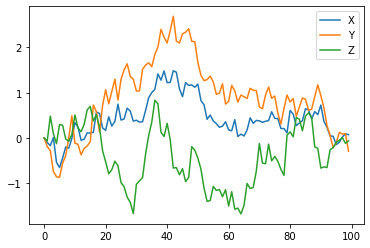

In [411]:
series = generate_data_3D(length = 100, num_variables = 3, A = [[0.0, 0.6, 0.3], [0.0, 0.9, 0.0], [0.0, 0.0, 0.9]], Vx = .1, Vy = .3, Vz = .3)
plt.plot(series)
plt.legend(labels = ["X", "Y", "Z"])

In [414]:
results = optimize.minimize(cost_3D, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
print(results.x)

p11, p22, p33, p12 = results.x[0:4]
P = np.array([[p11, p12, 1 - p11 - p12], [1 - p22 - (1 - (1 - p11 - p12) - p33), p22, 1 - (1 - p11 - p12) - p33], [1 - (1 - p12 - p22) - p33, 1 - p12 - p22, p33]])
print(P)

print(f"Effect of Z -> X: {P[0][2]}.")
print(f"Effect of Z -> Y: {P[1][2]}.")
print(f"Effect of Z -> Z: {P[2][2]}.")

print(f"Effect of X -> Z: {P[2][0]}.")

print(f"Relative effect of X <-> Y: {P[1][0] / P[0][1]}" )
print(f"Relative effect of X <-> Z: {P[2][0] / P[0][2]}" )
print(f"Relative effect of Y <-> Z: {P[2][1] / P[1][2]}" )

row_ind, col_ind = optimize.linear_sum_assignment(P)
P_matrix = np.array(np.zeros((3, 3)))
for i in range(3):
    P_matrix[col_ind[i]][row_ind[i]] = 1
print(P_matrix)

print(cost_3D(results.x))

[ 7.30523364e-02  2.27535596e-01  3.01480728e-01  5.18516676e-01
  9.29409593e-01  8.50062249e-01  8.25949628e-01 -5.35500842e-10
 -7.34256024e-03  4.23415536e-02]
[[0.07305234 0.51851668 0.40843099]
 [0.48237612 0.2275356  0.29008828]
 [0.44457154 0.25394773 0.30148073]]
Effect of Z -> X: 0.4084309878894493.
Effect of Z -> Y: 0.2900882839765389.
Effect of Z -> Z: 0.3014807281340118.
Effect of X -> Z: 0.4445715439173454.
Relative effect of X <-> Y: 0.930300108520858
Relative effect of X <-> Z: 1.088486322290703
Relative effect of Y <-> Z: 0.8754153200105838
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
0.07925995248091719


In [392]:
results = optimize.minimize(cost_3D_2, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
print(results.x)

p11, p12, p21, p13 = results.x[0:4]

P = np.array([[p11, 1 - p11 - p13, p13], [1 - p22 - (1 - p13 - p33), p22, 1 - p13 - p33], [1 - (1  - (1 - p11 - p13) - p22) - p33, 1  - (1 - p11 - p13) - p22, p33]])
print(P)

row_ind, col_ind = optimize.linear_sum_assignment(P)
P_matrix = np.array(np.zeros((3, 3)))
for i in range(3):
    P_matrix[col_ind[i]][row_ind[i]] = 1
print(P_matrix)

print(cost_3D_2(results.x))

[ 0.19654959  0.34762916  0.22004007  0.56946902  0.97981914  1.94457703
  1.94778272 -1.03053742 -1.02003633 -0.01089946]
[[ 0.19654959  0.2339814   0.56946902]
 [-0.34473599  1.13635314  0.20838285]
 [ 1.1481864  -0.37033454  0.22214814]]
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
2.8242015614818756


In [368]:
results = optimize.minimize(cost_3D_3, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
print(results.x)

p11, p12, p21, p22 = results.x[0:4]
P = np.array([[p11, p12, 1 - p11 - p12], [p21, p22, 1 - p21 - p22], [1 - p11 - p21, 1 - p12 - p22, 1 - (1 - p11 - p12) - (1 - p21 - p22)]])
print(P)

P = (P - 1) / -2
print(P)

row_ind, col_ind = optimize.linear_sum_assignment(P)
print(row_ind, col_ind)
P_matrix = np.array(np.zeros((3, 3)))
for i in range(3):
    P_matrix[col_ind[i]][row_ind[i]] = 1
print(P_matrix)

print(cost_3D_3(results.x))

[ 0.31579425  0.24119275  0.34542517  0.37674773  0.9748061   2.02559038
  2.0295676  -1.05498934 -0.98472606 -0.07435265]
[[0.31579425 0.24119275 0.443013  ]
 [0.34542517 0.37674773 0.2778271 ]
 [0.33878058 0.38205952 0.2791599 ]]
[[0.34210288 0.37940362 0.2784935 ]
 [0.32728741 0.31162613 0.36108645]
 [0.33060971 0.30897024 0.36042005]]
[0 1 2] [2 0 1]
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
43.06601416183934


In [307]:
v = np.random.uniform(0,1,10)
print(cost_3D(v))
print(cost_3D_2(v))

1037.1397463413812
1780.9615651188053


# Benchmark

In [1011]:
def cost_2D(variables, l = 0.1):
    p, a11, a12, a22 = variables
    
    A = np.array([[a11, a12], [0, a22]])
    P = np.array([[p, 1 - p], [1 - p, p]])
    
    cost = 0
    
    for t in range(1, length):
        val = np.matmul(P, series[t])
        est = np.matmul(A, np.matmul(P, series[t - 1]))
        cost += np.linalg.norm(val - est) ** 2
    
    return cost + l * (np.sum(np.abs(A)))

# Old equivalent but lengthier way to write cost_2D
def cost_2(variables, l = 0.01):
    p, axx, axy, ayy = variables
    p = round(p, 8)
    
    x_cost, y_cost = 0, 0
    for t in range(1, length):
        x_val = p * series[t][0] + (1 - p) * series[t][1]
        x_est = axx * (p * series[t - 1][0] + (1 - p) * series[t - 1][1]) \
              + axy * ((1 - p) * series[t - 1][0] + p * series[t - 1][1])
        x_cost += (x_val - x_est) ** 2
        
        y_val = p * series[t][1] + (1 - p) * series[t][0]
        y_est = ayy * ((1 - p) * series[t - 1][0] + p * series[t - 1][1])
        y_cost += (y_val - y_est) ** 2
    
    return x_cost + y_cost # + l * (abs(axx) + abs(axy) + abs(ayy))

[  0.57593768 -44.23875801  60.41919689   0.58333597]


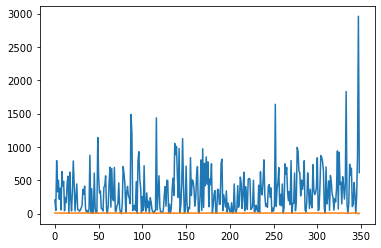

In [1014]:
series = np.array(np.zeros((349, 2)))
i = 0

with open("../data/pair0001.txt", "r") as f:
    for line in f:
        series[i] = line.rstrip().split(" ")
        i += 1

plt.plot(series)

# Minimize and get results
results = optimize.minimize(cost_2D, np.random.uniform(0, 0.4, 4)).x
print(results)